In [42]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import warnings

warnings.filterwarnings("ignore")

In [43]:
# Time
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2000, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
# Metatrader 5 Darwinex ETF
if mt5.initialize():
    symbols = mt5.symbols_get()
    list_tickers = [symbol.name for symbol in symbols if "ETF" in symbol.path]
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df = pd.DataFrame()
    for ticker, data in zip(list_tickers, database):
        temp_df = pd.DataFrame(data['close'], index=data['time'], columns=[ticker])
        df = pd.concat([df, temp_df], axis=1)
    df.index.names = ['time']
    df.index = pd.to_datetime(df.index, unit='s')
    data = df.dropna()

In [44]:
# SMAs
for col in list_tickers:
    data[f'pct {col}'] = data[col].pct_change()
    data[f'SMA3 {col}'] = data[col].rolling(3).mean().shift(1)
    data[f'SMA12 {col}'] = data[col].rolling(12).mean().shift(1)
    data[f'Momentum factor {col}'] = data[f'SMA3 {col}'] -\
        data[f'SMA12 {col}']
data = data.dropna()
# Split
split = int(0.6 * len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]
# Vectores mean y std
columns = [f'Momentum factor {col}' for col in list_tickers]
train_set_mean = train_set[columns].mean()
train_set_std = train_set[columns].std()
# Z-scores
train_set[columns] = (train_set[columns] - train_set_mean) / train_set_std
test_set[columns] = (test_set[columns] - train_set_mean) / train_set_std
train_set = train_set.dropna()
test_set = test_set.dropna()
# Medianas del Z-scores
median = train_set[columns].median()

<Axes: xlabel='time'>

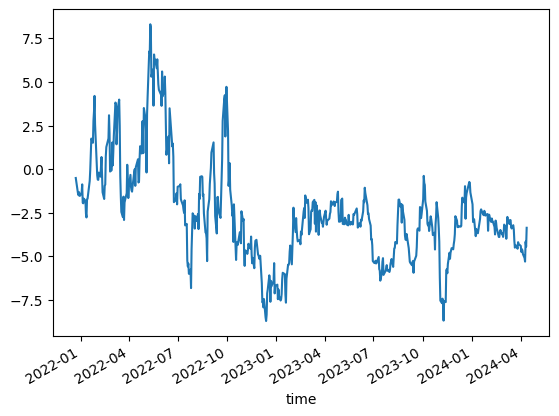

In [45]:
# Señales y beneficios
for i in range(len(columns)):
    # Columna para señal
    test_set[f'signal {columns[i]}'] = 0
    # -1 si z-score < median
    test_set.loc[test_set[f'{columns[i]}'] < median[i], f'signal {columns[i]}'] = -1
    # 1 si z-score > median
    test_set.loc[test_set[f'{columns[i]}'] > median[i], f'signal {columns[i]}'] = 1
    # Beneficio operación
    test_set[f'profit {columns[i]}'] = (test_set[f'signal {columns[i]}'].shift(1)) *\
        test_set[f'pct {list_tickers[i]}']
# Visualizar
test_set.filter(regex='^profit').dropna().cumsum().sum(axis=1).plot()